## Imports

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.losses import huber_loss, absolute_difference
from tensorflow.python.ops import math_ops
from gluoncv.data import VOCDetection
from gluoncv import data, utils
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder

## Constants

In [4]:
TRAIN_ROOT = '~/datasets/voc'
TEST_ROOT = '~/datasets/voc'

## Load data

In [5]:
# typically we use 2007+2012 trainval splits for training data
train_dataset = VOCDetection(root=TRAIN_ROOT, splits=[(2007, 'trainval'), (2012, 'trainval')])
# and use 2007 test as validation data
val_dataset = VOCDetection(root=TEST_ROOT, splits=[(2007, 'test')])

## Calculate confidence loss

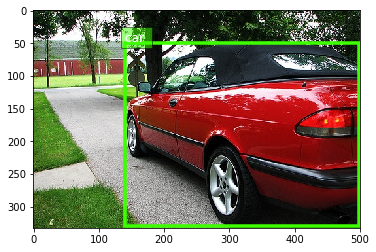

In [48]:
train_image, train_label = train_dataset[1]
bounding_boxes = train_label[:, :4]
class_ids = train_label[:, 4:5]
utils.viz.plot_bbox(train_image.asnumpy(), bounding_boxes, scores=None, labels=class_ids, class_names=train_dataset.classes)
plt.show()

In [25]:
ohe = OneHotEncoder()
ohe.fit(np.array(range(len(train_dataset.classes))).reshape(-1, 1))
labels = ohe.transform(class_ids).toarray()

logits = np.zeros((2, len(train_dataset.classes)))
logits[0, int(class_ids[0])] = 1.0
logits[1, 0] = 1.0

/home/cszsolnai/.conda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [29]:
with tf.Session() as sess:
    loss1 = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.constant(labels), logits=tf.constant(logits[0:1])).eval()
    loss2 = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.constant(labels), logits=tf.constant(logits[1:2])).eval()

    assert(loss1 < loss2)

## Calculate confidence loss with multiple objects per image

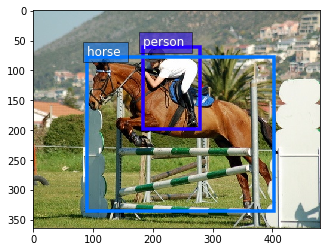

In [15]:
train_image, train_label = train_dataset[5]
bounding_boxes = train_label[:, :4]
class_ids = train_label[:, 4:5]
utils.viz.plot_bbox(train_image.asnumpy(), bounding_boxes, scores=None, labels=class_ids, class_names=train_dataset.classes)
plt.show()

In [37]:
ohe = OneHotEncoder()
ohe.fit(np.array(range(len(train_dataset.classes))).reshape(-1, 1))
labels = ohe.transform(class_ids).toarray().reshape((1, -1))

logits = np.zeros((2, len(train_dataset.classes)))
logits[0, int(class_ids[0])] = 1.0
logits[1, 0] = 1.0
logits = logits.reshape((1, -1))

/home/CW01/uib10737/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [21]:
with tf.Session() as sess:
    # TODO: what to test ?
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.constant(labels), logits=tf.constant(logits)).eval()

## Test one hot encoding with backgrounds conversion

In [12]:
train_image, train_label = train_dataset[1]
bounding_boxes = train_label[:, :4]
class_ids = train_label[:, 4:5]

In [42]:
logits = np.zeros((2, len(train_dataset.classes)))
logits[0, int(class_ids[0])] = 1.0

# In a real setting this means that there was a sufficient overlap (usually > 0.5) between the prior box and the assigned ground truth box
matches = np.array([True, False])

print(voc_class_to_ohe(matches, class_ids))

/home/CW01/uib10737/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


## Test smooth L1 loss

In [81]:
p = np.array([[1, 2, 3]]).reshape((1, 3))
q = np.array([[1.1, 2, 3.3]]).reshape((1, 3))


with tf.Session() as session:
    assert(abs(smoothL1_loss(predictions=tf.constant(p), labels=tf.constant(q)).eval() - 0.08) < 0.001)

## Test get relative gt box

In [96]:
ground_truth_box = np.array([[1.0, 1.0, 2.0, 2.0], [1.0, 1.0, 2.0, 2.0]])
default_box = np.array([[2.0, 2.0, 4.0, 2.0], [2.0, 2.0, 4.0, 2.0]])


with tf.Session() as session:
    assert(np.all(get_relative_gt_box(ground_truth_box, default_box)[0] == np.array([-0.25, -0.5, np.log(0.5), 0])))

## Calculate localization loss

In [120]:
'''
Indicators indicate if a valid object has been matched to the prior box belonging to this prediction
Indicators might come in different forms:
- binary: like the example below
- one hot encoding
- one hot encoding with background: as above, but the first position indicates background i.e. no object
'''
indicators = np.array([1, 0])
predictions = np.array([[0.749, -0.5, np.log(0.5), 0], [0.749, -0.5, np.log(0.5), 0]])
ground_truths = np.array([[1.0, 1.0, 2.0, 2.0], [1.0, 1.0, 2.0, 2.0]])
default_boxes = np.array([[2.0, 2.0, 4.0, 2.0], [2.0, 2.0, 4.0, 2.0]])


with tf.Session() as session:
    loss = localization_loss(indicators, predictions, ground_truths, default_boxes).eval(session=session)
    assert(abs(loss - 0.499/2) < 0.001)

## Calculate localization loss with real objects

In [119]:
# TODO

## Calculate confidence with multiple objects

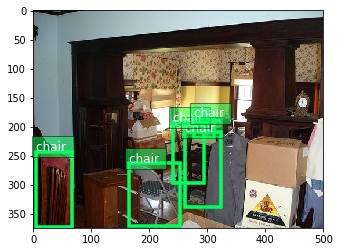

In [33]:
train_image, train_label = train_dataset[0]
bounding_boxes = train_label[:, :4]
class_ids = train_label[:, 4:5]
utils.viz.plot_bbox(train_image.asnumpy(), bounding_boxes, scores=None, labels=class_ids, class_names=train_dataset.classes)
plt.show()

In [42]:
ohe = OneHotEncoder()
ohe.fit(np.array(range(len(train_dataset.classes))).reshape(-1, 1))
labels = ohe.transform(class_ids).toarray()

# "Good" logits
logits1 = np.zeros_like(labels)
logits1[:, int(class_ids[0])] = 1.0

# Worse logits
logits2 = np.zeros_like(labels)
logits2[:, int(class_ids[0])] = 1.0
logits2[0, int(class_ids[0])] = 0.0
logits2[0, 0] = 1.0

/home/cszsolnai/.conda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [49]:
with tf.Session() as sess:
    loss1 = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.constant(labels.reshape((1, -1))), logits=tf.constant(logits1.reshape((1, -1)))).eval()
    loss2 = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.constant(labels.reshape((1, -1))), logits=tf.constant(logits2.reshape((1, -1)))).eval()
    assert(loss1 < loss2)

In [53]:
logits1.shape

(5, 20)

In [46]:
loss2

array([3.07815439, 2.07815439, 2.07815439, 2.07815439, 2.07815439])